# Convolutional Neural Networks (CNN)

This notebook covers Convolutional Neural Networks (CNN).

Specifically, we will attempt to solve the classic **MNIST Digit classification** problem using Keras.

Code and the information used in this notebook are adapted from keras.io and *Hands-On Machine Learning with Scikit-Learn, Keras & Tensorflow*

Before running this notebook, switch your runtime to a GPU.

In [1]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import matplotlib.pyplot as plt

2024-06-05 19:49:08.919249: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/zanealderfer/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/zanealderfer/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/zanealderfer/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or 

## Overview

### Convolutional Layers

The most important building block of CNN is the *convolutional layer*. Unlike the first *dense* layer in a typical neural network, the neurons of the first *convolutional* layer of a CNN are not connected to every single pixel in the input layer, but only to pixels in their *receptive field*. Similary, each neuron in later layers is connected only to neurons located within a small portion in the previous layer. This architecture allows a CNN to build up from lower-level features to higher-level features.




### Filters

Each layer of a CNN can learn multiple filters or *convolutional kernels*. The following cells in this section demonstrate the effects of applying a filter to an image. In most CNNs, the weights of each kernel are learned during training.

In [2]:
import numpy as np
from sklearn.datasets import load_sample_image
import matplotlib.pyplot as plt

# load sample images
china = load_sample_image('china.jpg') / 255
flower = load_sample_image('flower.jpg') / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

Plot the original images.

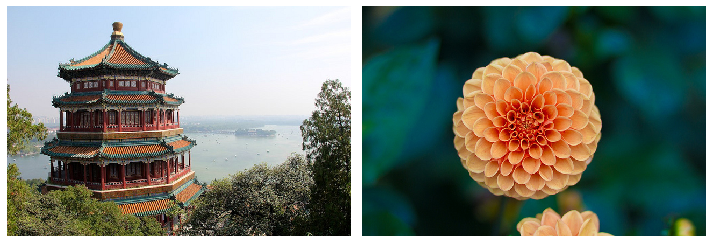

In [3]:
# utility functions for plotting images
def plot_image(image):
    plt.imshow(image, cmap = 'gray', interpolation = 'nearest')
    plt.axis('off')

def plot_color_image(image):
    plt.imshow(image, interpolation = 'nearest')
    plt.axis('off')

fig, axes = plt.subplots(1, 2, figsize = (10, 6))

plt.sca(axes[0])
plot_color_image(images[0])

plt.sca(axes[1])
plot_color_image(images[1])

plt.tight_layout()
plt.show()

Create 2 filters: one to emphasize vertical lines, the other to emphasize horizontal lines.

In [4]:
# create 2 filters
filters = np.zeros(shape=(7, 7, channels, 2), dtype = np.float32)
filters[:, 3, :, 0] = 1  # vertical filter
filters[3, :, :, 1] = 1  # horizontal filter

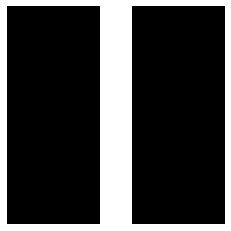

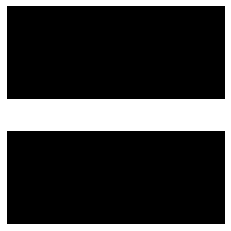

In [5]:
plot_image(filters[:, :, 0, 0])
plt.show()
plot_image(filters[:, :, 0, 1])
plt.show()

Next, we will apply the filters to each image. When plotting we'll crop each image and convert to greyscale, in order to emphasize the effects of applying the filters.

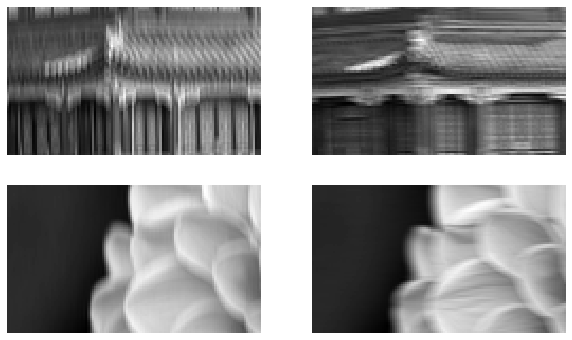

In [6]:
import tensorflow as tf
outputs = tf.nn.conv2d(images, filters, strides = 1, padding = 'SAME')

def crop(images):
    return images[150:220, 130:250]

plt.figure(figsize = (10,6))
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(crop(outputs[image_index, :, :, feature_map_index]))
plt.show()

### Pooling Layers

The goal of pooling layers is to *subsample* (i.e., shrink) an input image. The resulting image reduces the computational load of the network, its memory usage, and the number of parameters which limits the risk of overfitting.

A pooling layer typically works on every input channel independently, so the output depth is the same as the input depth. However, a pooling neuron has no weights; all it does is aggregate the inputs using an aggregation function such as `max` or `mean`.

### MaxPooling

MaxPooling uses the aggregation function `max`. It will take the maximum of all the values in the filter matrix.

The output of the pooling layer can be calculated using the following formula:

$$ O_{w} = \frac{(I_{w} - F_{w} +1)}{S_{w}} $$
<br>  
$$ O_{h} = \frac{(I_{h} - F_{h} +1)}{S_{h}} $$

Where `I` denotes the input size, `F` denotes the filter size or receptive field size and `S` denotes stride size.

The input and output features maps have different dimensions. Let's say
we have an input layer with size `(width, height)` and a filter with
dimensions `(filter_w, filter_h)`. After applying the convolution, the
dimensions of the output layer are `(width - filter_w + 1, height - filter_h + 1)`.

There are other types of [pooling layers](https://keras.io/api/layers/pooling_layers/) but MaxPooling is the most common.

Next, we'll demonstrate the effects of `MaxPooling` on the first image from above.

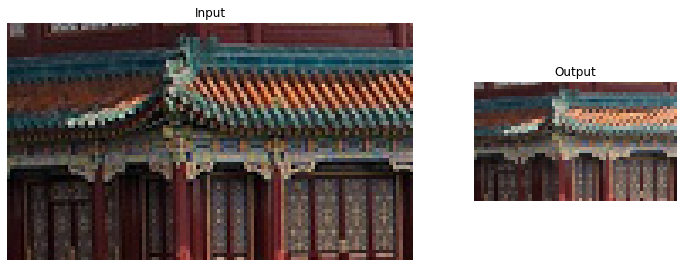

In [7]:
from tensorflow import keras
import matplotlib as mpl

max_pool = keras.layers.MaxPool2D(pool_size = 2)

cropped_images = np.array([crop(image) for image in images], dtype = np.float32)
output = max_pool(cropped_images)

fig = plt.figure(figsize = (12, 8))
gs = mpl.gridspec.GridSpec(nrows = 1, ncols = 2, width_ratios = [2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title('Input', fontsize = 12)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax1.axis('off')
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title('Output', fontsize = 12)
ax2.imshow(output[0])  # plot the output for the 1st image
ax2.axis('off')
plt.show()

## MNIST Digit Classification

The MNIST digit classification dataset contains handwritten digits 0-9 as grayscale images. There are 70,000 total images; 60,000 in the training set, and 10,000 in the testing set.

This MNIST dataset is a subset of a very large dataset available from NIST. This dataset is a good place to start for classification, as it has been preprocessed and normalized already. All the images are centered and cropped to 28x28 size. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal effort on preprocessing and formatting.

> More information on the dataset can be found http://yann.lecun.com/exdb/mnist/

In [8]:
# We have digits from 0-9, which gives us total 10 classes.
num_classes = 10

# As already mentioned, all the images are resized into 28x28 therefore our input shape is 28x28x1
input_shape = (28, 28, 1)

### Step 1 - Loading the Data

`load_data()`

This function loads any dataset available in the `keras.datasets` library. For this example, we are loading the **MNIST** dataset.

This function also splits the data into training and testing.

In [9]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

### Step 2 - Scaling

Each color channel is represented by a number from 0 to 255. We need to scale these features into 0 to 1 floating point which can done by dividing each pixel by 255.

In [10]:
# Scale images to the [0, 1] range
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

### Step 3 - Reshaping the Data

Our images have shape 28x28; we need to change the dimension to 28x28x1.

In [11]:
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

print(x_train.shape[0], 'train samples')
print('x_train shape:', x_train.shape)
print(x_test.shape[0], 'test samples')
print('x_test shape:', x_test.shape)

60000 train samples
x_train shape: (60000, 28, 28, 1)
10000 test samples
x_test shape: (10000, 28, 28, 1)


### Step 4 - One-Hot Encode the Target

Our target variable is a number between 0 to 9 which denotes the actual digit in the image. We will convert this vector to a series of binary vectors, one for each class.

In [12]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print(y_train[0]) # target for the first sample in the training set
print(y_train[1]) # target for the second sample in the training set


[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


### Step 5 - Build the CNN

Our CNN consists of the following.

**Input Layer** with shape 28 x 28 x 1

**Conv2D Layer** with filter size 3x3, output depth 32 and RELU activation function

The output of this hidden layer can be calulated using the formula `width -filter_width +1, height - filter_height+1, output depth`

- Input shape 28x28
- Filter shape 3x3
- Output depth 32
   
Output shape:

$$ 28 - 3 + 1, 28 - 3 + 1, 32) = (26, 26, 32) $$

**MaxPooling2D Layer**

In our case we have used a 2x2 filter size, so this step will choose the maximum value from the 4 values in the pool. The max value will be resulted as output and will replace all the 4 pixels in the output layer. Similarly, it will calculate the output by sliding over all the pixels in the layer.

Using the formula in the [Pooling layer](#pooling) section, we will now calculate the output of the MaxPooling layer for our problem. The pooling layer does not affect depth. So the output of the pooling layer will be `(Ow, Oh, depth)`.

- Input size = (26, 26)   
- Filter size = (2, 2)
- Stride size = (2, 2)
    
$$ O_{w} = \frac{26 - 2}{2} + 1  = 13$$
<br>
$$ O_{h} = \frac{26 - 2}{2} + 1  = 13$$
<br>
The final output of the MaxPooling layer is (13, 13, 32)



**Conv2D Layer**  

A second hidden `CONV2D` layer with filter size as 3x3, output depth of 64 and RELU activation function.

- Input shape = 13x13
- Filter shape = 3x3
- Output depth = 64
   
Output shape:

$$ (13 - 3 + 1, 13 - 3 + 1, 64) = (11, 11, 64) $$

**MaxPooling2D Layer**

A second max pooling layer with filter size 2x2.

$$ O_{w} = \frac{11 - 2}{2} + 1  = 5.5 = 5$$
<br>
$$ O_{h} = \frac{11 - 2}{2} + 1  = 5.5 = 5$$
                  
Final output of MaxPooling layer is (5, 5, 54)

**Flatten Layer**

Flattening a tensor means to reduce to a single dimension. We flatten the output of the convolutional layers to create a single feature vector. This vector is connected to the final classification model, which is called a fully-connected layer.

$$ 5*5*64 = 1600 $$

**Dense Layer**

This is the final layer of our model. We use a softmax activation function.

In [13]:
model = keras.Sequential(
    [   keras.Input(shape=input_shape),

        layers.Conv2D(32, kernel_size=(3, 3), activation = 'relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Conv2D(64, kernel_size=(3, 3), activation = 'relu'),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Flatten(),
        layers.Dense(num_classes, activation = 'softmax'),
    ])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 13, 13, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense (Dense)               (None, 10)                1

### Step 6 - Compile the Model

We will compile the model with batch size 128 and 15 epochs. We will use the `adam` optimizer and `categorical_crossentropy` for loss.

In [14]:
batch_size = 128
epochs = 5

model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

model.fit(x_train, y_train,
          batch_size = batch_size,
          epochs = epochs,
          validation_split = 0.1)

Epoch 1/5
422/422 [==============================] - 36s 80ms/step - loss: 0.3086 - accuracy: 0.9141 - val_loss: 0.0786 - val_accuracy: 0.9787
Epoch 2/5
422/422 [==============================] - 33s 78ms/step - loss: 0.0793 - accuracy: 0.9760 - val_loss: 0.0578 - val_accuracy: 0.9837
Epoch 3/5
422/422 [==============================] - 32s 76ms/step - loss: 0.0581 - accuracy: 0.9823 - val_loss: 0.0470 - val_accuracy: 0.9873
Epoch 4/5
422/422 [==============================] - 33s 78ms/step - loss: 0.0476 - accuracy: 0.9854 - val_loss: 0.0486 - val_accuracy: 0.9877
Epoch 5/5
422/422 [==============================] - 33s 79ms/step - loss: 0.0391 - accuracy: 0.9881 - val_loss: 0.0404 - val_accuracy: 0.9878


### Step 6 - Evaluate the Model

In [15]:
score = model.evaluate(x_test, y_test, verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.03767600283026695
Test accuracy: 0.9876000285148621


## Building a Better MNIST Classifier

The last model scored high on accuracy. But can we do better?

The following model reaches about 99.2% accuracy on the test set. This places this model roughly in the top 20% in the [MNIST Kaggle competition](https://www.kaggle.com/c/digit-recognizer/) (if we ignore the models with an accuracy greater than 99.79% which were most likely trained on the test set, as explained by Chris Deotte in [this post](https://www.kaggle.com/c/digit-recognizer/discussion/61480)). Can you do better? In the next lab, we'll cover **data augmentation**, one of the methods needed to acheive higher accuracy rates on this task.

In [16]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([

    keras.layers.Conv2D(32, kernel_size = 3,
                        padding = 'same',
                        activation = 'relu'),

    keras.layers.Conv2D(64,
                        kernel_size = 3,
                        padding = 'same',
                        activation = 'relu'),

    keras.layers.MaxPool2D(),

    keras.layers.Flatten(),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(128, activation = 'relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation = 'softmax')
])
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'nadam',
              metrics=['accuracy'])

model.fit(x_train, y_train,
          epochs = 10,
          validation_split = 0.1)

model.evaluate(x_test, y_test)

Epoch 1/10
1688/1688 [==============================] - 203s 118ms/step - loss: 0.1904 - accuracy: 0.9430 - val_loss: 0.0445 - val_accuracy: 0.9868
Epoch 2/10
1688/1688 [==============================] - 199s 118ms/step - loss: 0.0811 - accuracy: 0.9755 - val_loss: 0.0377 - val_accuracy: 0.9893
Epoch 3/10
1688/1688 [==============================] - 206s 122ms/step - loss: 0.0617 - accuracy: 0.9814 - val_loss: 0.0390 - val_accuracy: 0.9907
Epoch 4/10
1688/1688 [==============================] - 200s 118ms/step - loss: 0.0490 - accuracy: 0.9851 - val_loss: 0.0404 - val_accuracy: 0.9902
Epoch 5/10
1688/1688 [==============================] - 199s 118ms/step - loss: 0.0405 - accuracy: 0.9868 - val_loss: 0.0342 - val_accuracy: 0.9913
Epoch 6/10
1688/1688 [==============================] - 204s 121ms/step - loss: 0.0364 - accuracy: 0.9888 - val_loss: 0.0366 - val_accuracy: 0.9905
Epoch 7/10
1688/1688 [==============================] - 199s 118ms/step - loss: 0.0305 - accuracy: 0.9904 - val_

[0.03258442133665085, 0.9925000071525574]